In [1]:
!pip install noisereduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from scipy.fft import fft, fftshift, fftfreq, ifft, ifftshift, dct
import sklearn as sk
import scipy as sc
import scipy.signal as scp
import numpy.random as rnd
from scipy.io import wavfile
from IPython.display import Audio
import noisereduce as nr
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split
from sklearn import tree
import os

Fontconfig error: Cannot load default config file: No such file: (null)


In [2]:
# Variables
data_path = "./data/1/"
data_folder = os.getcwd() + "/data"
fs = 48000

In [221]:
# Utility Functions
import librosa
def create_dataset(root):
    """
    Apply function to all files under root
    returns 1 if succesfull, -1 if not.
    """
    data    = []
    labels  = []
    lengths = []
    
    for dirpath, dirnames, filenames in os.walk(root):
        for filename in filenames:

            label = dirpath[-1]
            _ , signal   = wavfile.read(f"{dirpath}/{filename}")
            
            
            cleaned       = clean_data(signal)
            
            features   = MFCC(cleaned, fs)
            features[features!=features] = 0
            features   = np.insert(features, 0, len(cleaned))

            feat_noisy = MFCC(generate_noisy(cleaned, 0.05), fs)
            feat_noisy[feat_noisy!=feat_noisy] = 0
            feat_noisy = np.insert(feat_noisy, 0, len(cleaned))

            feat_noisy2 = MFCC(generate_noisy(cleaned, 0.1), fs)
            feat_noisy2[feat_noisy2!=feat_noisy2] = 0
            feat_noisy2 = np.insert(feat_noisy, 0, len(cleaned))
            
            if label != "0":              
                data.append(features.flatten())
                labels.append(label)
                
                data.append(feat_noisy.flatten())
                labels.append(label)
                
                data.append(feat_noisy2.flatten())
                labels.append(label)


            
    df = pd.DataFrame(data, index=labels).sort_index()
    df[df!=df] = 0

    return df

def generate_noisy(data, ratio):
    """
    Generate noisy variant of data.
    noise is additive and normally distributed
    """
    return data + rnd.normal(0,1,len(data)) * max(abs(data)) * ratio

def clean_data(data):
    """
    remove silent spaces and noise
    """
    return data[abs(data) > abs(data).mean()*0.05] / max(abs(data))
    
def read_wav(path):
    """
    Reads wav file
    Returns time and signal vectors
    """
    fs, signal = wavfile.read(path)
    t = np.arange(0,len(signal)/fs, 1/fs)
    return [t, signal]

def remove_noise(data):
    """
    Simple function to remove the noise from the signal data
    """
    return nr.reduce_noise(y=data, sr=fs)

def predict_input(audioname, model, scaler):
    _, test_sample = wavfile.read(f"./predict/{audioname}")
    clean = clean_data(test_sample)
    features = MFCC(clean, fs)
    features[features!=features] = 0
    features = np.insert(features, 0, len(clean))
    features = np.pad(features, (0, 1214-len(features)))
    features = np.tile(features, (10,1))
    features = scaler.transform(features)

    pred = model.predict(features)
    vals, counts = np.unique(pred, return_counts = True)
    print(vals)
    return vals[0]
        

In [22]:
# Feature extraction functions
# http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

def mel(f):
    """
    Transform to mel space
    """ 
    return 1127*np.log(1+f/700)

def imel(m):
    """
    Transform from mel space to frequency domain
    """
    return 700*(np.exp(m/1127) - 1)

def MFCC(signal, fs):
    """
    HAS TO BE DEBUGGED
    Compute mel frequency coefficients
    """
    # compute spectrum for frames of 25 ms with 10 ms overlaps
    Nfft = 2048
    f, t, Z = stft(x=signal, fs=fs, window='hann', nperseg=fs*25e-3, noverlap=fs*10e-3, nfft=Nfft)
    Nf = len(t) # number of frames in signal
    Ncut = int(np.ceil(Nfft/6)) # 342 point spectrum
    # turn each FFT window into power spectrum by scaling
    P = np.zeros((Nf,Ncut))
    for n in range(Nf):
        Fcut = Z[:Ncut,n] # compute the 342 point power spectrum
        P[n] = abs(Fcut)**2/Ncut
    
    # upper and lower frequency bounds in Hz converted to Mel scale
    upperHz = 8000
    lowerHz = 300
    upperMel = mel(upperHz)
    lowerMel = mel(lowerHz)
    m = np.linspace(lowerMel,upperMel,28) # mel filterbank
    h = imel(m) # filterbank in frequency domain
    f = np.floor((Nfft+1)*h/fs) # filterbank as FFT bin indices
    f = f.astype(int)
    
    # construct filters in filterbank
    mfilters = np.zeros((26,342))
    for n in range(26):
        for i in range(len(f)):
            if i != 0 and i != len(f)-1:
                for iless in range(f[i]-f[i-1]):
                    mfilters[n,f[i-1]+iless] = iless/(f[i]-f[i-1])
                for imore in range(f[i+1]-f[i]):
                    mfilters[n,f[i]+imore] = 1-imore/(f[i+1]-f[i])
    
    M = np.zeros((Nf,26))
    # filter data with filterbank
    for n in range(Nf):
        for c in range(26):
            M[n,c] = sum(mfilters[c]*P[n])
    
    # take the log discrete cosine transform of frame spectra
    mfcc = np.zeros((Nf,12))
    for n in range(Nf):
        mfcc[n] = dct(np.log(M[n]), type=3)[1:13]
    
    # return ndarray with rows representing timeframes and 
    return mfcc


In [23]:
dataset = create_dataset(data_folder)

labels = dataset.index
features = dataset.values


/tmp/ipykernel_197/3733836163.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _ , signal   = wavfile.read(f"{dirpath}/{filename}")
/tmp/ipykernel_197/3257212282.py:61: RuntimeWarning: divide by zero encountered in log
  mfcc[n] = dct(np.log(M[n]), type=3)[1:13]


In [24]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

encoder = LabelEncoder()

X = dataset.values
y = dataset.index

results = []

labels = [str(i) for i in range(1,10)]


cms = np.zeros(shape=(9,9))
clrs = []

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        stratify=y)

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    
    model = RandomForestClassifier(n_estimators=300,
                                   max_features="log2",
                                   criterion="gini",
                                   class_weight="balanced")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
     
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cms += cm
    clrs.append(classification_report(y_test, y_pred, target_names=labels))

    results.append(cross_val_score(model, X, y, cv=5).mean())
    


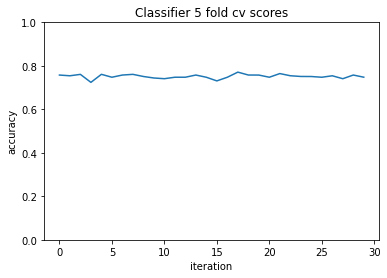

In [51]:
plt.plot(results)
plt.ylim(0,1)
plt.ylabel("accuracy")
plt.xlabel("iteration")
plt.title("Classifier 5 fold cv scores")
plt.savefig("scores")
plt.show()

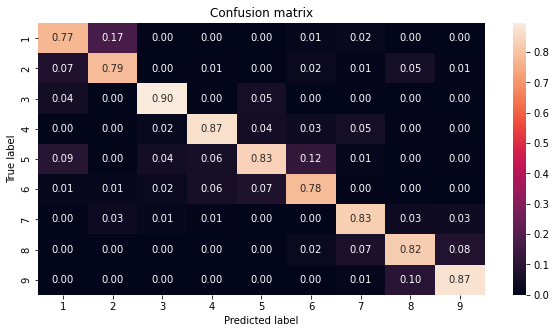

              precision    recall  f1-score   support

           1       0.67      0.57      0.62         7
           2       0.62      0.71      0.67         7
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00         6
           5       0.88      1.00      0.93         7
           6       1.00      0.83      0.91         6
           7       0.60      0.86      0.71         7
           8       1.00      0.57      0.73         7
           9       0.75      0.86      0.80         7

    accuracy                           0.80        60
   macro avg       0.84      0.80      0.81        60
weighted avg       0.83      0.80      0.80        60



'\n    precision = TP/(TP+FP)\n    recall = TP/(TP+FN)\n    f1-score = (2*recall*precision)/(recall+precision)\n    accuracy = (TP+TN)/(TP+TN+FP+FN)\n'

In [50]:
import seaborn as sns
# Normalize confusion matrix
cms = cms / cms.sum(axis=0)

plt.subplots(figsize=(10,5))
sns.heatmap(cms, annot=True,
           fmt=".2f",
           xticklabels = labels,
           yticklabels = labels)

plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("CM")
plt.show()

print(clrs[-1])
"""
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1-score = (2*recall*precision)/(recall+precision)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
"""

In [61]:
filename = "kahdeksan_r"
audio_sample = read_wav(f"./predict/{filename}.wav")
Audio(audio_sample, rate=fs)


In [62]:
prediction = predict_input(filename,model,scaler)
print(f"The number you said was {prediction}")

['7']
The number you said was 7
